In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import Union, Optional, Dict, Tuple, Any

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score

In [2]:
electronics = pd.read_csv('../datasets/consumer_electronics_sales/consumer_electronics_sales_data.csv').dropna(how='all')
electronics 

,ProductID,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent
0,5874,Smartphones,Other Brands,312.949668,18,0,2,1,0
1,5875,Smart Watches,Samsung,980.389404,35,1,7,2,1
2,5876,Tablets,Samsung,2606.718293,63,0,1,5,1
3,5877,Smartphones,Samsung,870.395450,63,1,10,3,1
4,5878,Tablets,Sony,1798.955875,57,0,17,3,0
...,...,...,...,...,...,...,...,...,...
8995,14869,Smart Watches,Samsung,1041.149163,36,1,16,4,0
8996,14870,Smartphones,Samsung,1485.694311,57,0,5,1,1
8997,14871,Headphones,Samsung,2887.369597,28,0,18,4,0
8998,14872,Tablets,HP,1490.453964,38,0,4,2,1


In [3]:
electronics.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductID             9000 non-null   int64  
 1   ProductCategory       9000 non-null   object 
 2   ProductBrand          9000 non-null   object 
 3   ProductPrice          9000 non-null   float64
 4   CustomerAge           9000 non-null   int64  
 5   CustomerGender        9000 non-null   int64  
 6   PurchaseFrequency     9000 non-null   int64  
 7   CustomerSatisfaction  9000 non-null   int64  
 8   PurchaseIntent        9000 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 1.5 MB


In [5]:
electronics['ProductCategory'].value_counts()

ProductCategory
Laptops          1842
Smartphones      1841
Smart Watches    1810
Tablets          1769
Headphones       1738
Name: count, dtype: int64

In [6]:
electronics['ProductBrand'].value_counts()

ProductBrand
Samsung         1854
HP              1820
Sony            1790
Other Brands    1776
Apple           1760
Name: count, dtype: int64

In [8]:
print("ProductPrice: " ,electronics['ProductPrice'].min(), " - ", electronics['ProductPrice'].max())

ProductPrice:  100.3763582884275  -  2999.852253399973


In [9]:
print("CustomerAge", electronics['CustomerAge'].min(), " - ", electronics['CustomerAge'].max())

CustomerAge 18  -  69


In [10]:
electronics['CustomerGender'].value_counts()

CustomerGender
1    4580
0    4420
Name: count, dtype: int64

In [11]:
electronics['PurchaseFrequency'].value_counts()

PurchaseFrequency
7     506
19    500
12    499
14    489
3     488
4     481
17    480
5     478
10    477
11    469
16    468
8     466
15    465
13    464
9     463
18    461
2     455
6     452
1     439
Name: count, dtype: int64

In [12]:
electronics['CustomerSatisfaction'].value_counts()

CustomerSatisfaction
3    1848
2    1814
4    1798
1    1775
5    1765
Name: count, dtype: int64

In [13]:
electronics['PurchaseIntent'].value_counts()

PurchaseIntent
1    5098
0    3902
Name: count, dtype: int64

In [14]:
def show_classification_report(y_true, y_pred):
    print("        [ CLASSIFICATION REPORT ]")
    print(classification_report(y_true, y_pred))
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")

In [15]:
def classification_plots(model, x_test, y_test):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax)
    plt.title('ROC-AUC Curve')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [25]:
def preprocess(
    data: pd.DataFrame
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    data = data.copy()
    data_info: Dict[str, Any] = {}

    if 'ProductID' in data.columns:
        data.drop('ProductID', axis=1, inplace=True)

    categorical_cols = ['ProductCategory', 'ProductBrand']
    data = pd.get_dummies(data, columns=categorical_cols, dtype='int8')
    data_info['categorical_cols'] = categorical_cols

    scaler = StandardScaler()
    cols_to_scale = [
        'ProductPrice', 
        'CustomerAge',
        'PurchaseFrequency',
    ]
    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
    data_info['cols_to_scale'] = cols_to_scale
    data_info['scaler'] = scaler
    
    dtype_map = {
        'ProductPrice': 'float32',
        'CustomerAge': 'float32',
        'PurchaseFrequency': 'float32',
        'CustomerGender': 'int8',
        'CustomerSatisfaction': 'int8',
    }
    data = data.astype(dtype_map)

    data_info['dtype_map'] = dtype_map
    data_info['data_columns'] = data.columns.tolist()

    return data, data_info

In [26]:
def preprocess_test(data: pd.DataFrame, data_info: Dict[str, Any]) -> pd.DataFrame:
    data = data.copy()

    if 'ProductID' in data.columns:
        data.drop('ProductID', axis=1, inplace=True)

    categorical_cols = data_info['categorical_cols']
    existing_cat_cols = [c for c in categorical_cols if c in data.columns]
    data = pd.get_dummies(data, columns=existing_cat_cols, dtype='int8')

    scaler = data_info['scaler']
    cols_to_scale = data_info['cols_to_scale']
    if all(col in data.columns for col in cols_to_scale):
        data[cols_to_scale] = scaler.transform(data[cols_to_scale])

    data = data.reindex(columns=data_info['data_columns'], fill_value=0)

    dtype_map = data_info['dtype_map']
    for col, dtype in dtype_map.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)

    return data

In [27]:
y = electronics['PurchaseIntent'].astype('int8')
x = electronics.drop('PurchaseIntent', axis=1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [29]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7200, 8), (1800, 8), (7200,), (1800,))

In [30]:
x_train_p, data_info = preprocess(x_train)

In [31]:
x_train_p

,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,ProductCategory_Headphones,ProductCategory_Laptops,ProductCategory_Smart Watches,ProductCategory_Smartphones,ProductCategory_Tablets,ProductBrand_Apple,ProductBrand_HP,ProductBrand_Other Brands,ProductBrand_Samsung,ProductBrand_Sony
6157,0.397684,-1.078214,0,-0.371255,4,0,0,0,1,0,0,0,0,0,1
2923,-0.558084,-0.148584,1,-1.287306,2,0,0,1,0,0,1,0,0,0,0
5155,0.503563,0.913850,1,-1.653726,2,0,0,0,0,1,0,0,0,1,0
31,-0.222567,-1.011812,1,1.277637,4,0,0,0,0,1,0,1,0,0,0
7628,0.071966,-1.078214,0,-0.371255,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,-1.450017,0.515437,1,-0.737675,5,0,1,0,0,0,0,0,0,0,1
7891,1.524405,-0.148584,0,-1.104096,3,1,0,0,0,0,0,0,1,0,0
4859,-0.654061,-0.746203,0,-0.188045,3,0,0,0,0,1,0,0,0,0,1
3264,1.278222,-1.144616,1,-1.653726,3,1,0,0,0,0,0,0,0,1,0


In [32]:
data_info

{'categorical_cols': ['ProductCategory', 'ProductBrand'],
 'cols_to_scale': ['ProductPrice', 'CustomerAge', 'PurchaseFrequency'],
 'scaler': StandardScaler(),
 'dtype_map': {'ProductPrice': 'float32',
  'CustomerAge': 'float32',
  'PurchaseFrequency': 'float32',
  'CustomerGender': 'int8',
  'CustomerSatisfaction': 'int8'},
 'data_columns': ['ProductPrice',
  'CustomerAge',
  'CustomerGender',
  'PurchaseFrequency',
  'CustomerSatisfaction',
  'ProductCategory_Headphones',
  'ProductCategory_Laptops',
  'ProductCategory_Smart Watches',
  'ProductCategory_Smartphones',
  'ProductCategory_Tablets',
  'ProductBrand_Apple',
  'ProductBrand_HP',
  'ProductBrand_Other Brands',
  'ProductBrand_Samsung',
  'ProductBrand_Sony']}

In [33]:
x_test_p = preprocess_test(x_test, data_info)

In [34]:
x_test_p

,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,ProductCategory_Headphones,ProductCategory_Laptops,ProductCategory_Smart Watches,ProductCategory_Smartphones,ProductCategory_Tablets,ProductBrand_Apple,ProductBrand_HP,ProductBrand_Other Brands,ProductBrand_Samsung,ProductBrand_Sony
4424,1.109649,1.644274,0,-0.371255,2,0,1,0,0,0,0,0,0,0,1
1726,1.013868,1.710676,0,-0.004835,3,0,0,0,1,0,1,0,0,0,0
7895,-0.666282,1.113057,1,-0.188045,1,1,0,0,0,0,0,0,0,0,1
7586,-0.490059,-0.015780,0,-1.470516,4,1,0,0,0,0,0,0,1,0,0
1986,1.170621,1.312263,0,-1.104096,2,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,-1.625724,-0.414193,1,1.460847,2,1,0,0,0,0,0,0,1,0,0
4394,-0.447584,-1.543029,1,-0.554465,1,0,1,0,0,0,0,0,1,0,0
7193,-0.431142,-1.543029,1,0.911216,5,0,0,0,1,0,0,0,1,0,0
6280,-1.050408,-0.148584,0,0.178375,4,0,1,0,0,0,0,0,0,0,1


In [35]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_p, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [36]:
xgb_pred_train = xgb_model.predict(x_train_p)
xgb_pred_train

array([0, 1, 1, ..., 0, 0, 1], shape=(7200,))

In [37]:
show_classification_report(y_train, xgb_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3134
           1       0.99      0.98      0.98      4066

    accuracy                           0.98      7200
   macro avg       0.98      0.98      0.98      7200
weighted avg       0.98      0.98      0.98      7200

Overall Accuracy: 0.9831


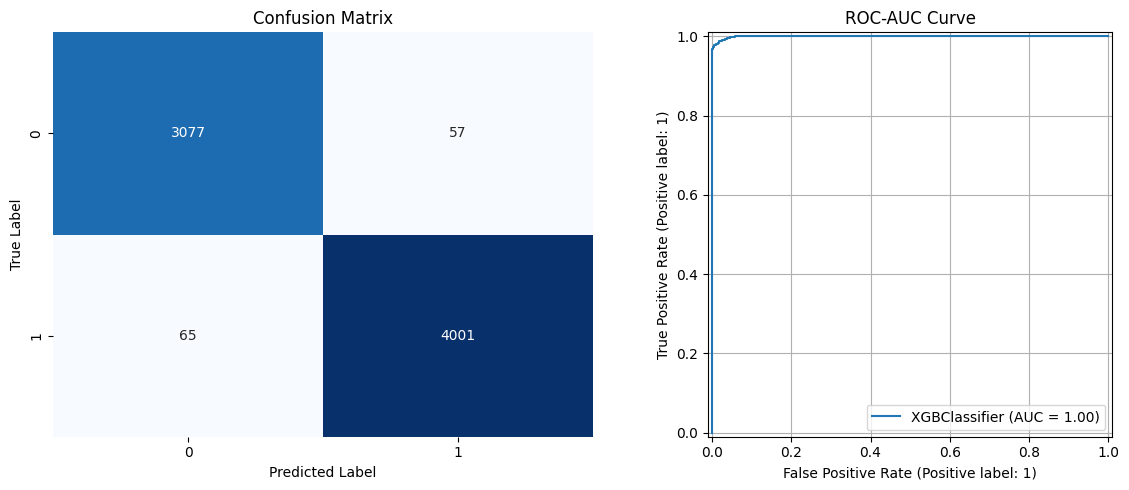

In [38]:
classification_plots(xgb_model, x_train_p, y_train)

In [39]:
xgb_pred = xgb_model.predict(x_test_p)
xgb_pred

array([0, 0, 1, ..., 1, 1, 0], shape=(1800,))

In [40]:
show_classification_report(y_test, xgb_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       768
           1       0.96      0.96      0.96      1032

    accuracy                           0.96      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.96      0.96      0.96      1800

Overall Accuracy: 0.9556


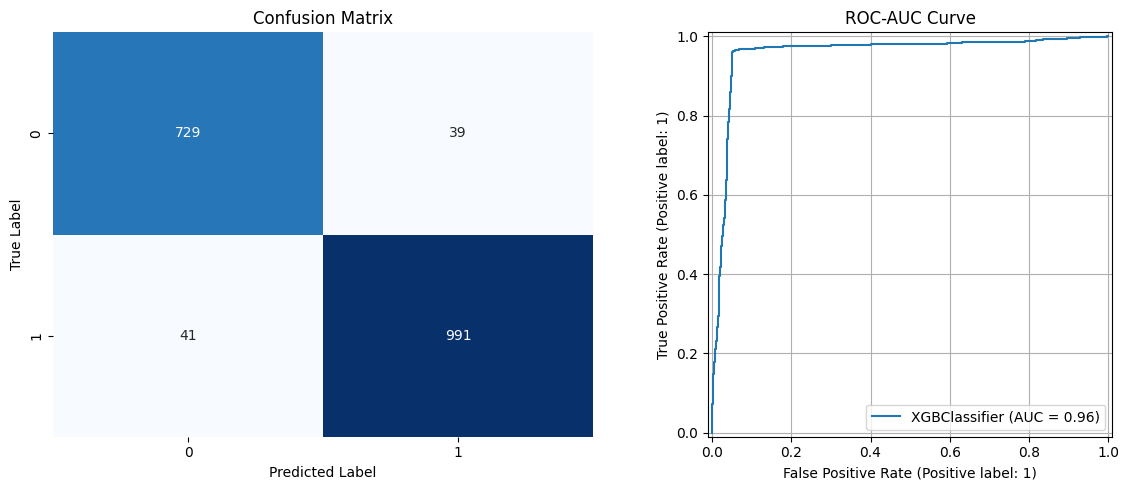

In [41]:
classification_plots(xgb_model, x_test_p, y_test)